<div>
    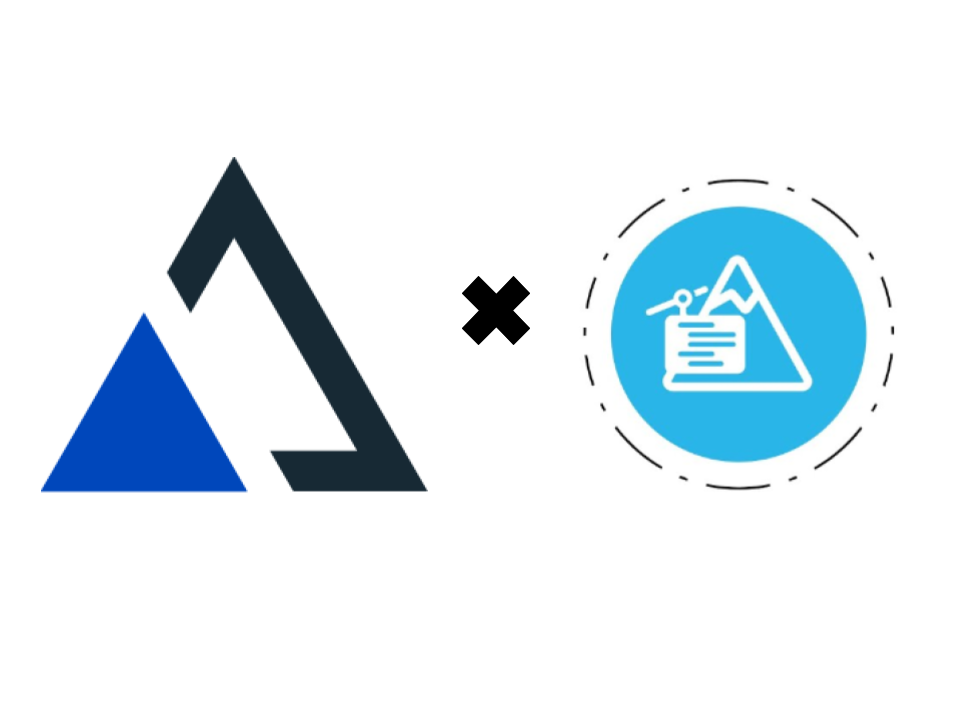
</div>

<h1 style = "text-align: center;"><font size = 8px color = "#0047BB">Intermediate AI-Link x Snowpark  </font></h1

<p style="margin-left: 25px;">
For the purposes of this demo we are going to be using the <b>Walmart M5 Dataset</b> <a href = "https://www.kaggle.com/competitions/m5-forecasting-accuracy"> from Kaggle</a>. This dataset contains historical sales information </p>across several locations in three states. As they are the <b>largest domestic retail store</b>, it's safe to assume Walmart has a lot of sales data. The M5 dataset represents only a fraction of their stores and it is 60 million rows of data. There are 4,630 stores in the country, so as one would expect we are presented with a problem. Data movement would be pricey and time consuming, so <b>how can we avoid this problem?</b> <font color = "#62c4f5"><b>Snowpark</b></font> lets us edit our data where it is; we take the code to the data instead of the data to the code. 

<p style="margin-left: 25px;">
Yet when we look at tens of millions of rows in their raw state, we have no way of understanding what is happening. <b>Trends reveal themselves on a </b></p><b>scale we can't see on a row to row basis</b>, so we need some way to make this data more digestable without moving all of it. This is where our <font color = "#1b1899"><b>semantic model</b></font> comes in. We can transform the data without worrying about moving it while still allowing for individual users to query this transformed data. 

<p style="margin-left: 25px;">
Our business team has decided they would like forecasted information on <b>units sold for any given item on any given day in any given store</b>. How </p>can we offer insights on such a granular level while still hitting our data engineering team policy of <b>at least 85% accuracy</b> on forcasting? We can use <font color = "#1b1899"><b>AI-Link</b></font>, to pull some of our transformed data to a local environment where we can expirement, then from there we can proceed to <font color = "#62c4f5"><b>Snowpark</b></font> and <b>expand our local model to a global model</b> that we use across all of our stores. With AI-Link's capabilities we can ensure our ML models operate off of the same data transformations our business team does. 

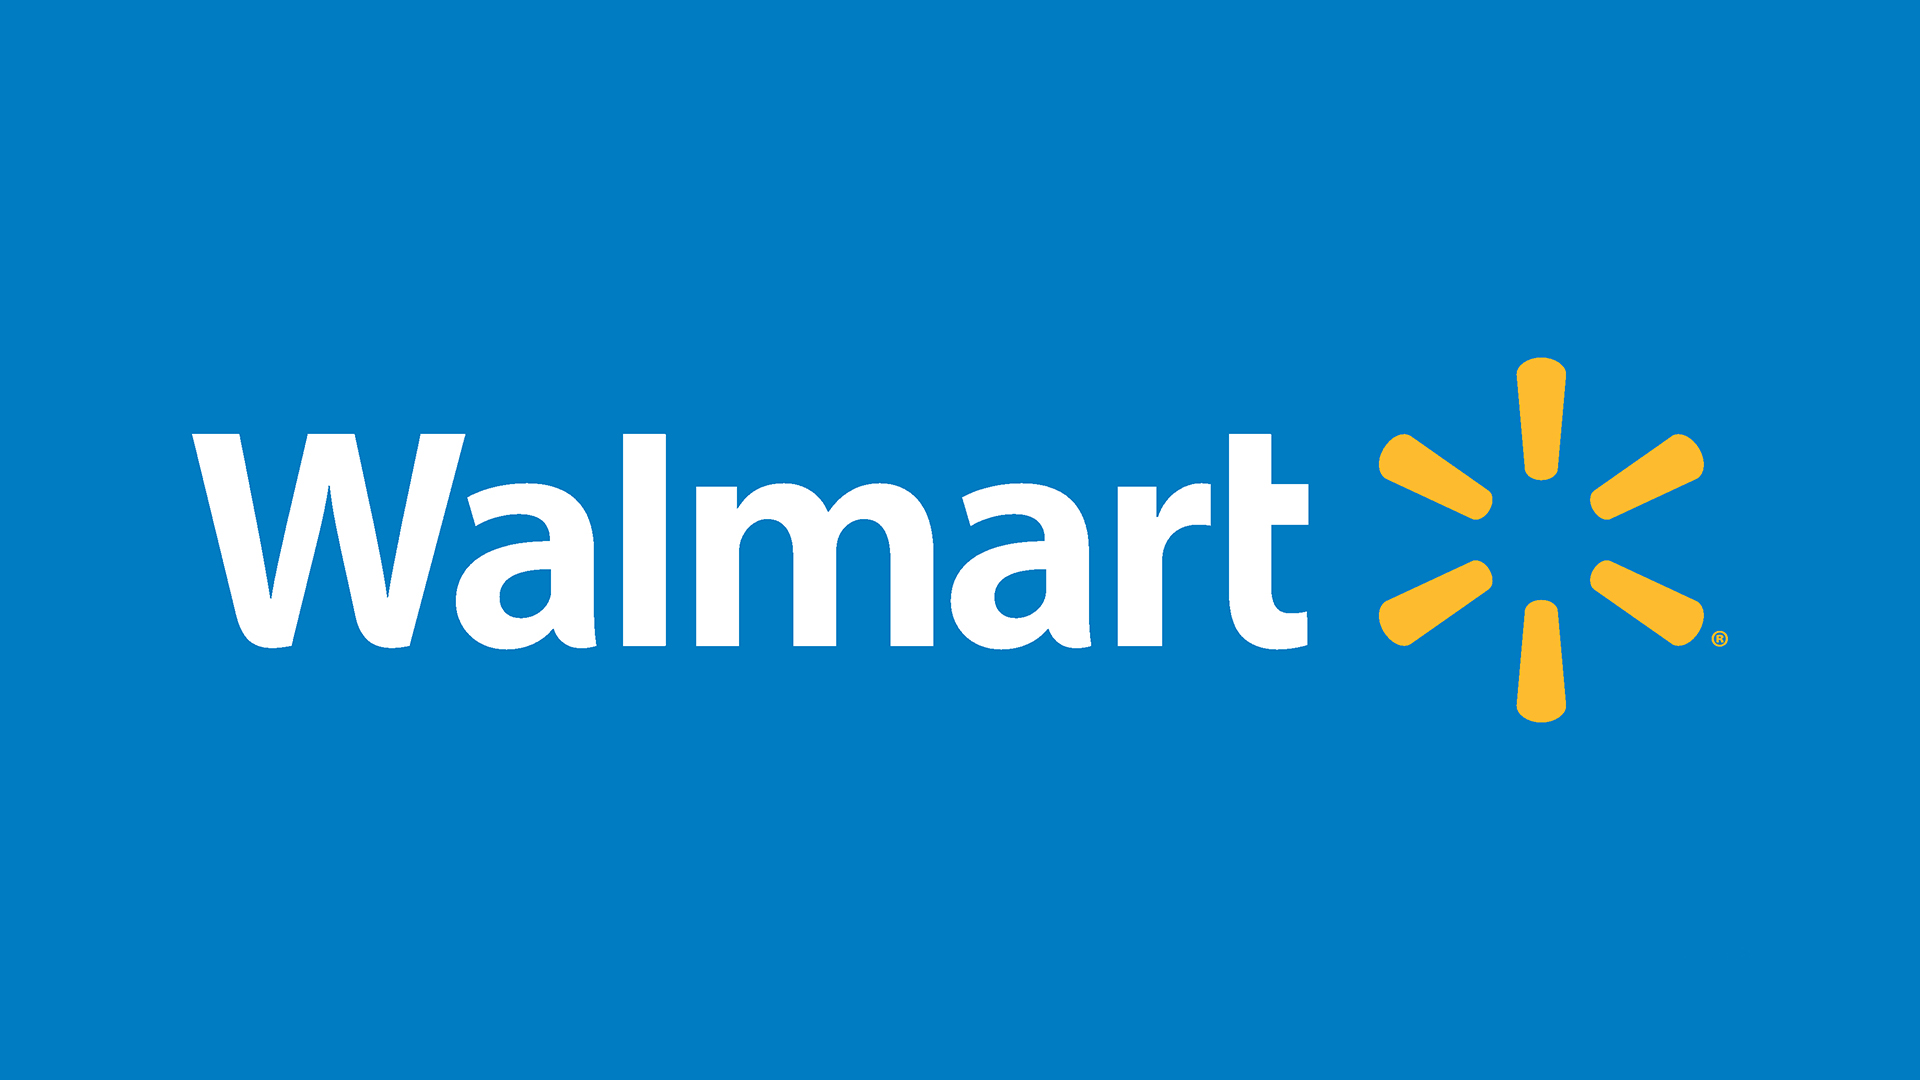

<h6>Prerequistes & Assumptions:</h6>
<ol><li><b>AtScale Python API</b> installed as detailed <a href = "https://github.com/AtScaleInc/python-api"> on our GitHub </a></li>
    <li><b>Snowpark</b> installed as detailed <a href = "https://docs.snowflake.com/en/developer-guide/snowpark/python/setup"> here </a></li>
    <li>You have your environment configured with <a href = "https://drive.google.com/file/d/1vs-CEc3K42n1WDGBmfqwZxyT0tLTi89d/view?usp=drive_link"> these dependencies for Snowpark </a></li>
    <li>You have configured your <b>AtScale and Snowflake permissions</b> into a local JSON</li>
    <li>You are using Python <b>3.8</b></li>
    <li>You have already created a <b>semantic model</b> in AtScale</li>
    <li>You are <b>fine with data movement</b>, and are only looking to explore Snowpark and model training with AtScale</li>
    </ol>

<h1 style = "text-align: center;"><font color = "#2097BB">Let's get set up!</font></h1>

In [ ]:
# AtScale Imports
from atscale.client import Client
from atscale.data_model import DataModel
from atscale.project import Project
from atscale.connection import Connection
from atscale.eda.feature_engineering import *
from atscale.base import enums
from atscale.base.enums import Aggs, PandasTableExistsActionType
from atscale.db.connections.snowflake import Snowflake

# Snowpark imports
from snowflake.snowpark.functions import (
    array_construct,
    call_udf,
    col,
    lit,
    month,
    sum,
    udf,
    year,
)
from snowflake.snowpark.session import Session
from snowflake.snowpark.types import (
    DateType,
    FloatType,
    IntegerType,
    StringType,
    StructField,
    StructType,
    Variant,
)
from snowflake.snowpark.version import VERSION
import snowflake.snowpark.types as T


#Other Packages
import pandas as pd
import numpy as np
import os
import sys
import pkg_resources
import json
import joblib

In [ ]:
# Read our permissions json
with open("/permissions") as file:
    permissions = json.load(file)

<br><br><p style = "text-align: center"><i><font color = "#092755">If you are ever curious if a cell is Snowpark code, AtScale code, a combination of both, or neither, simply go to View -> Cell Tool Bar -> Tags to see the tags attached to each cell which will explain the type of code.</font></i></p><br><br>

<h6>Every AtScale-AILink connection has a few main components:</h6>
<ol><li><b>Client Definition</b>- Define a local Client with AtScale permission info</li>
    <li><b>Client.connect( )</b>- Establish an AtScale connection</li>
    <li><b>Project</b>- Select a project from our AtScale instance</li>
    <li><b>Data Model</b>- A data model is a cube from your AtScale UI</li>
    </ol>
    

In [ ]:
client = Client(
    server=permissions["atscale_server"],
    organization=permissions["atscale_organization"],
    username=permissions["atscale_username"],
    password=permissions["atscale_password"],
)

In [ ]:
client.connect()

In [ ]:
project = client.select_project(name_contains=permissions["atscale_project"])

In [ ]:
data_model = project.select_data_model(name_contains = permissions["atscale_data_model"])

<h6>Every Snowflake-Snowpark connection has a two main components:</h6>
<ol><li><b>Connection Parameters</b>- We point to a specific schema where we will be performaing all our actions. We select a role, being cautious of role because snowflake permissions are tied to the role. Also note that account and username are not the same; your account is an instance of Snowflake, and your username is specific to each person</li>
    <li><b>Session</b>- A session is a callable local snowflake connection. We are going to use this to read and write data from our specific Snowflake schema with our specific role</li>
    </ol>


In [ ]:
connection_parameters = {
    "account": permissions["snowflake_account"],
    "user": permissions["snowflake_username"],
    "password": permissions["snowflake_password"],
    "role": permissions["snowflake_role"],
    "warehouse": permissions["snowflake_warehouse"],
    "database": permissions["snowflake_database"],
    "schema": permissions["snowflake_schema"],
}

In [ ]:
session = Session.builder.configs(connection_parameters).create()

Packages are a crucial part of Snowpark user defined functions (UDFs) and stored procedures (SPROCs). Snowpark has a list of approved python packages accessible by ```SELECT * FROM information_schema.packages WHERE language = 'python';``` in a Snowflake worksheet. 

To ensure that we are using the correct versions of our Snowpark packages, we'll make a JSON to store the versions of every package we will use. Writing this as a JSON will allow us to use this file in later notebooks.

In [ ]:
env = dict(tuple(str(ws).split()) for ws in pkg_resources.working_set)

sp_udf_packages = [
    "snowflake-snowpark-python",
    "pandas",
    "scikit-learn",
    "lightgbm",
    "xgboost",
    "cachetools",
    "joblib",
    "imbalanced-learn",
    "atscale",
    "sys",
    "json",
]

packages_version = dict((k, env[k]) for k in sp_udf_packages if k in env)

with open("packages_version.json", "w") as outfile:
    outfile.write(json.dumps(packages_version))

In [ ]:
with open("packages_version.json") as f:
    packages_version = json.load(f)

Lastly in our set up let's <b>create a stage called DEMO_STAGE.</b>  Stages in Snowflake allow us to store files such as models and pure Python packages. Each SPROC and UDF needs a stage to be written to. If we want to run SQL in our notebook we can call <code>session.sql()</code> and pass the SQL string. 

The downsides to this are the necessary SQL knowledge and departure from raw Python. 

In [ ]:
session.sql("CREATE STAGE IF NOT EXISTS INTERMEDIATE_STAGE").collect()

<h1 style = "text-align: center;"><font color = "#1287GB">Road Map</font></h1

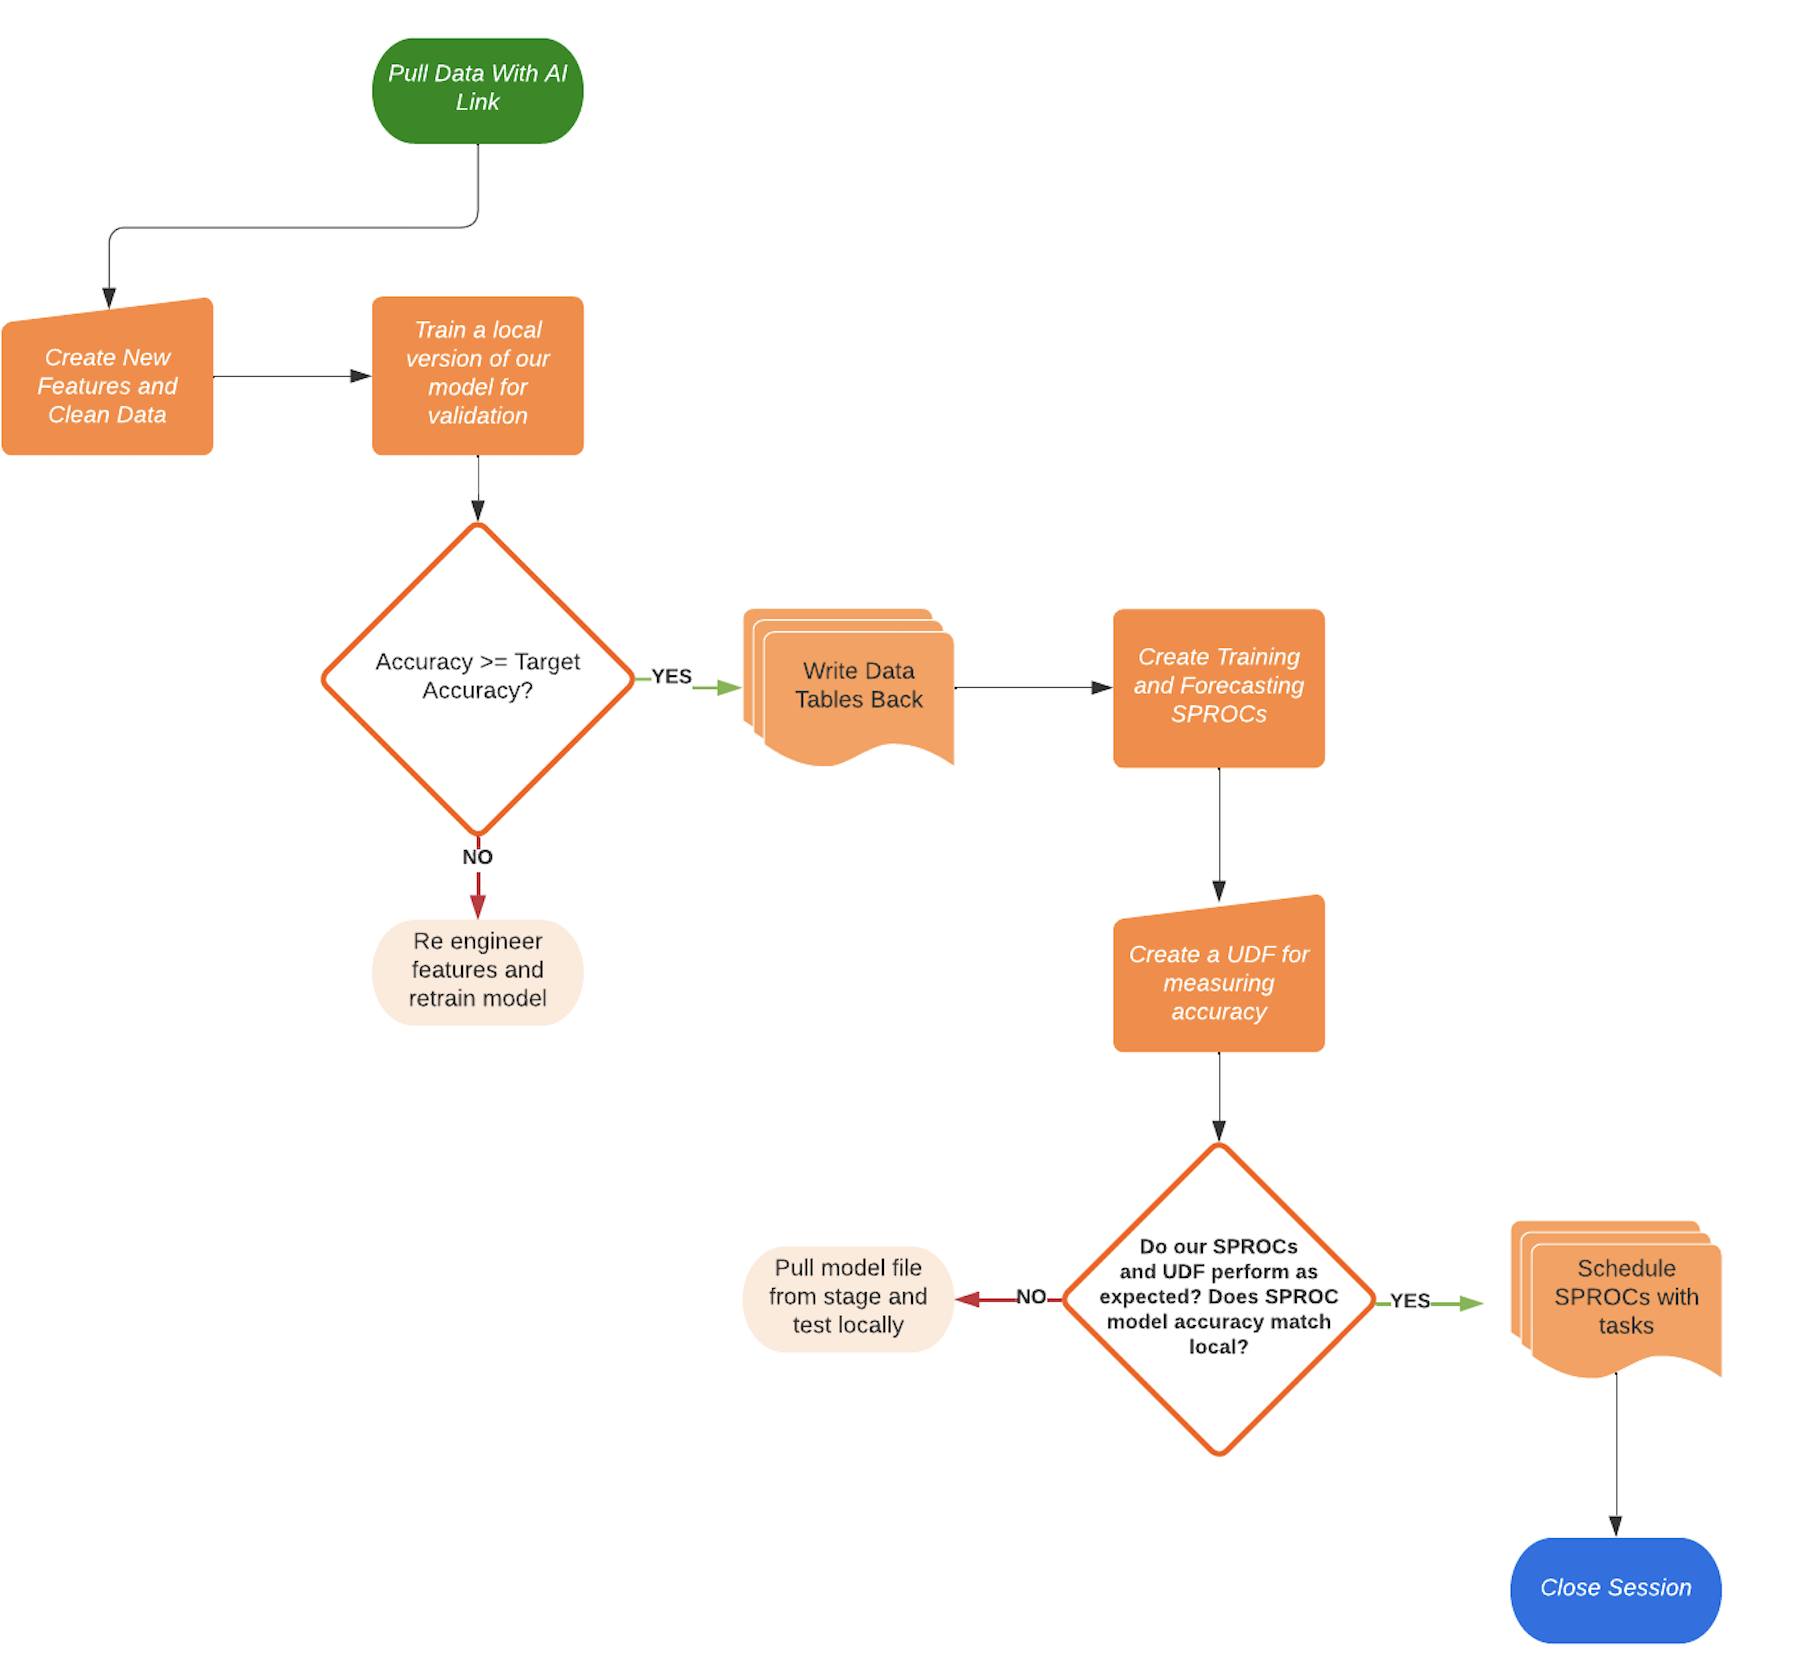

<h1 style = "text-align: center;"><font color = "#0097GG">Let's do some feature engineering</font></h1

<h3>Create previous week units sold average by day</h3>
<p>We can use AtScale to <b>create a new rolling feature called avg_prev_week_units_sold.</b> To use AtScale's <code>create_rolling_features()</code>, we need to pass a few variables, but let's focus on the <i>time length</i> and the <i>aggregation types</i>. With these two parameters, we are telling the function that the new feature we are creating should be generated based on an average over 7 time units, or as it comes out, an average over a week.</p>

In [ ]:
#if you've already created these features, delete them like so:
data_model.delete_measures(["avg_prev_week_units_sold"])
data_model.delete_measures(["total_units_sold_28_days"])

In [ ]:
data_model.create_rolling_features(
    new_feature_name="avg_prev_week_units_sold",
    numeric_feature_name="total_units_sold",
    time_length=7,
    hierarchy_name="date_hierarchy",
    level_name="date",
    aggregation_types=enums.Aggs["AVG"],
)

data_model.create_rolling_features(
    new_feature_name="total_units_sold_28_days",
    numeric_feature_name="total_units_sold",
    time_length=28,
    hierarchy_name="date_hierarchy",
    level_name="date",
    aggregation_types=enums.Aggs["SUM"],
)


<h3>Read our data</h3>
<p>Now that we have done some feature engineering, let's read our data into a DataFrame called df where we will <b>perform local transformations</b>. We also use the <code>%%time</code> to view the functions runtime.</p> The experienced AI-Link user might notice that this is effectively a get_data_direct call. What we are doing is using get_database_query to generate a sql query with our semantic model. Then we are using Snowpark's <code>session.sql()</code> command to create a new Snowpark DF with this query. Notice how this runs pretty quickly because we are getting the data from Snowflake directly. 

In [ ]:
%%time
query = data_model.get_database_query(feature_list = ['date', 'store', 'item', 
                          'total_sales','total_units_sold', 
                          'previous_days_units_sold',
                          'avg_prev_week_units_sold', 'day_of_week', 
                          'event_name_1', 'total_units_sold_28_days',
                          'total_units_sold_30_prd_mv_avg'
                         ])

df = session.sql(query).to_pandas()
df.head()

<b>Clean Numeric Columns</b>
<br>Replace every <i>nan with 0</i> so any calculations we want to do will run.

In [ ]:
df["previous_days_units_sold"].replace(np.nan, 0, inplace=True)
df["total_units_sold"].replace(np.nan, 0, inplace=True)
df["total_sales"].replace(np.nan, 0, inplace=True)

<h4>Unit Price: total sales / total units sold</h4>
Make a new column called unit_price, which we can calculate by dividing the total sales by the total units sold, then <i>replace any infs with nans</i> so we can drop them out later. We switch them to nans so <code>dropna()</code> functions on them.

In [ ]:
df["unit_price"] = df["total_sales"] / df["total_units_sold"]
df["unit_price"].replace(np.inf, np.nan, inplace=True)

<h4>Holiday: Bool for when event_name_1 != 'none'</h4>
Holidays impact sales, so make a new column called holiday and assign a 1 for holidays and a 0 otherwise.

In [ ]:
df["event_name_1"].replace("", "none", inplace=True)
df["holiday"] = np.where(df["event_name_1"] != "none", 1, 0)

<h4>Late in Month: if date is in 20s or 30s</h4>
Oftentimes managers have to restock early in the month meaning stocks can be high or low late in the month, impacting sales, so make a new column, using <code>iterrows()</code> to track if the date is <i>past the 20th of the month</i>. If it is, we will consider that day late in month and assign a 1.

In [ ]:
%%time
lateinmonth = []

for index, row in df.iterrows():
    if int(str(row["date"])[-2]) > 1:
        lateinmonth.append(1)
    else:
        lateinmonth.append(0)

df["lateinmonth"] = lateinmonth

<h4>Finalize our data</h4>
Lastly, drop out our non-numeric columns, and run <code>dropna()</code> to remove all rows that have a np.nan value in them. This will ensure that our model can run smoothly over all 9 of our input columns, and our 1 output column. 

In [ ]:
df = df.drop(["item", "store", "date", "event_name_1"], axis=1)
df = df.dropna()

# Check the shape
print(df.shape)

<h1 style = "text-align: center;"><font color = "#0097GG">Logistic Regression</font></h1

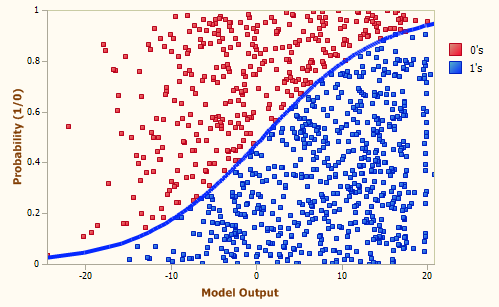

For this demo, we are going to be using logistic regression as our model. We chose logistic regression for two main reasons. 1) It trains quickly and is effective and 2) It avoids hand-waving around AI, ML, and Modeling topics which often get skipped over. Logistic regression is a binary classifier, meaning it takes any given number of inputs and outputs a 1 or a 0. In the example above, the model is dividing 2 dimensional space into 1s and 0s, but as we increase dimensionality this stays the same. All we are doing is classifying inputs as a binary.

<h4>Target Column</h4>
This column will be our output, and will be a binary <font style = "text-decoration: underline">calculated by determining whether the current days sales are 5 units over the previous weeks' daily average units sold.</font> This column is our 1s and 0s for training as discussed above. 

In [ ]:
above_average_sales = []

for index, row in df.iterrows():
    if (int(row["total_units_sold"])) > (row["avg_prev_week_units_sold"] + 5):
        above_average_sales.append(1)
    else:
        above_average_sales.append(0)

df = df.drop(["total_units_sold"], axis=1)

<h1 style = "text-align: center;"><font color = "#004AB8">Local Model Training</font></h1>

Now we need to <b>test whether this measure will be valuable.</b> AtScale gives us a hunch it will be, but to validate our belief, let's train a version of our model locally. To do this we are going to use sklearn's logistic regressor, along with some other data processing. Note that all the code for the next few cells is neither AtScale nor Snowpark. 

We have cleaned our data and developed a hypothesis, think of this next set of cells as preliminary testing. Our goal here is to establish a relation on a small scale so we can use Snowpark to bring it to the large scale. 

<i>If this proves to be of value, we can move forward with deploying UDFs and SPROCs.</i>

In [ ]:
df.head()

<h4>Train and Test sets</h4>
Split the data into two new numpy arrays called <b>X for input</b> and <b>Y for output.</b> Then use sklearn's train test split to <b>divide X and Y into train and test sets</b> with 75% training data and 25% testing data. 

In [ ]:
X = np.array(df)
Y = np.array(above_average_sales)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=0
)

<h4>Fitting and Predicting</h4>
Train the model by calling <code>LogisticRegression.fit()</code>. After fitting the model,  predict for the test data so we can check the accuracy. 

In [ ]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression(max_iter=1000)
logReg.fit(X_train, y_train)

predictions = logReg.predict(X_test)

<h4>Accuracy</h4>
Finally, check the accuracy of the model using a confusion matrix. If the outputs are different than what you expected, check the true and false postives and negatives. 

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)
TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

accuracy = (TP + TN) / (TP + FP + TN + FN)
print(accuracy * 100, "%")

<b>We have now confirmed that this model is useful,</b> as it has an accuracy higer than our taget.  <i>Now we need to move this process to the Snowflake side</i> and automate it using Snowpark. Here's what we have completed so far in our flow chart.

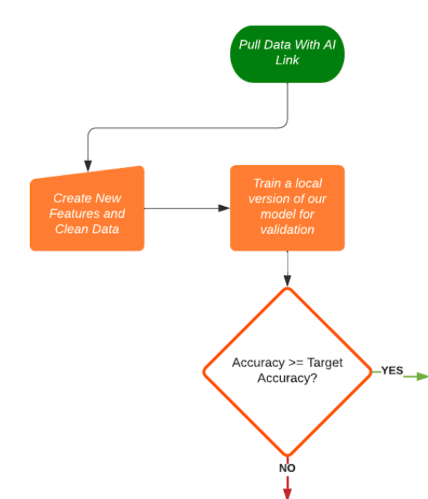

<h1 style = "text-align: center;"><font color = "#327FF1">Write Back to Snowflake</font></h1>

Now that we know our model is worth training and deploying with Snowpark we need to transfer our data transformations to Snowflake. This step is crucial due to Snowpark's lack of external network access. Because we can only access servers which Snowpark deems as internal, we need to write our data to an internal location. If external network access were possible we wouldn't need this step. 

First, ensure that we have our input and target in one table so later we can cut down on the number of tables we need. Then, create 3 new Snowpark DataFrames with <code>session.create_dataframe()</code>. To do this we are going to pass each of these new Snowpark DFs different slices of our pandas DF. <i>Notice how the definition of the DataFrames takes longer than the writing to a table</i>; this is because using the session creates these dataframes on Snowflake servers. 

You can ignore the warning thrown, we don't care about perserving the pandas indexes in our new data tables.

In [ ]:
df["target"] = above_average_sales

In [ ]:
import warnings
warnings.filterwarnings("ignore")
session.write_pandas(df[-5000:], table_name='DEMO_TESTING_DATA', overwrite = True)
session.write_pandas(df[-10000:-5000].drop(['target'], axis = 1), table_name='DEMO_FORECAST_DATA', overwrite = True)
session.write_pandas(df[:40000], table_name='DEMO_TRAINING_DATA', overwrite = True)

<h1 style = "text-align: center;"><font color = "#092755">Automate it using Snowpark</font></h1>

In this demo we are training a model that can be used to <font style = "text-decoration: underline">predict if daily sales will exceed last weeks average by a specific margin</font>. This information will be useful to store managers, <b>but we need to offer them a prediction every single day,</b> based upon the previous day's information. <b>But we also don't want to train a new model everyday.</b> This data only represents 14 stores over the course of a 16 months and it makes up over 50,000 rows, if we try to train a new model everyday, <font color = "#cc0000">compute costs would be astronomic.</font>

Where does that leave us? Well, we want to forecast every night after a store closes, but we don't want to train everyday, so we will <b>need to split our forecasting and training into two seperate Stored Procedures.</b>

Additionally, every few weeks trends may change, and managers may want to double check the model's accuracy. Therefore, we also want a <b>UDF to measure the accuracy of our model.</b> 

Well how can we achieve this?
<ol><li>Write a SPROC to <b>train our model</b> and write it to a stage we can read from every time we want it. </li>
    <li>Create a SPROC to <b>predict using our model</b> by reading it from a stage then using <code>LogisticRegression.predict()</code>.</li>
    <li>Make a UDF to read our model, predict based on it, and <b>assess if we correctly predicted.</b></li></ol>


<h4>Model Training Stored Procedure</h4>
Define a SPROC called <code>bi_class_demo</code> to train and save our model. We need to define our function with a few different parameters, <i>specifically a Session variable</i> to make it a SPROC. Additonally we will also use a <code>T.Variant</code> return type, but in reality we will only be returning a string here. <code>T.Variant</code> is using the Snowpark Types module (imported as T). 

Firstly, load our data from the table into a pandas DataFrame, to do this use <code>session.table</code> to read 'training_table' (a parameter), to a Snowpark DataFrame, then use <code>to_pandas()</code> to convert to a Pandas DataFrame because we need pandas' structure for training. Then split back into X and Y, and train like we did locally.

Once the model is trained use <code>joblib.dump()</code> to compress our model file, and then write it to the demo stage using the <code>session.file.put()</code>. Lastly, return a success so the user knows the function has proceded. 

In [ ]:
def bi_class_demo(
    session: Session, training_table: str, feature_cols: list, target_col: str
) -> T.Variant:
    # Read, split, and standardize data + fit model
    local_training_data = session.table(training_table).to_pandas()
    X = local_training_data[feature_cols]
    Y = local_training_data[target_col]
    logReg = LogisticRegression(max_iter=1000)
    logReg.fit(X, Y)

    # Save model on demo stage
    model_file = os.path.join("/tmp", "Demo_Model")
    joblib.dump(logReg, model_file)
    session.file.put(model_file, "@intermediate_stage", auto_compress=False, overwrite=True)

    return "model trained!"

<h4>Registering a Stored Procedure</h4>
<i>In order to call this SPROC, we need to register it on a Snowflake stage.</i> A registration call takes a number of parameters. <code>func</code>, <code>name</code>, <code>is_permanent</code>, and <code>replace</code> are all pretty self explanitory. The <code>stage_location</code> is self explanatory as well, but <strong>note that in your Snowflake UI the SPROC will appear in the Procedures tab,</strong> not under the stage you specified. The packages parameter takes in the name of the packages, but also -- importantly -- the versions of them. 

<b>MAKE SURE TO USE SNOWFLAKE SNOWPARK PYTHON 1.3.0.</b> More recent versions are very tempermental. 

We are using the versions of our packages which we read at the start of the notebook

In [ ]:
%%time

bi_class_demo = session.sproc.register(func=bi_class_demo, name='bi_class_demo_deployed', is_permanent=True, 
                                       replace=True, stage_location='@intermediate_stage',
                                       packages=[f'snowflake-snowpark-python=={packages_version["snowflake-snowpark-python"]}'
                                                          ,f'scikit-learn=={packages_version["scikit-learn"]}'
                                                          ,f'imbalanced-learn=={packages_version["imbalanced-learn"]}'
                                                          ,f'joblib=={packages_version["joblib"]}'])

<h4>Calling a Stored Procedure in Python</h4>
We can call the SPROC by using the version we defined locally above. Notice this code isn't executing locally, but it is being called locally. 

In [ ]:
%%time
training_table = 'demo_training_data'
feature_cols = ["total_sales", "previous_days_units_sold", 
"avg_prev_week_units_sold", "day_of_week", "total_units_sold_28_days",
"total_units_sold_30_prd_mv_avg","unit_price", "holiday", "lateinmonth"]
target_col = "target"

out = bi_class_demo(training_table, 
                    feature_cols,
                    target_col,
                    session=session)
print(out)

<h4>Forecast Stored Procedure</h4>
Now create a Stored Procedure that forecasts data into the forecast table. Firstly, <font style = "text-decoration: underline">clear the session's packages and imports</font> so we can add only what we need for this instance. Then, use <code>add_import()</code> to add the model from the demo stage. Next, use <code>joblib.load()</code> to load the model from the file in the demo stage. Then, read the forecast table and predict to it. After that, write these predictions back to the forecast table. Overwrite the table so we drop it before writing if it exists. Finally, we return sucess.

In [ ]:
%%time

session.clear_imports()
session.clear_packages()
session.add_import("@INTERMEDIATE_STAGE/Demo_Model")

def forecast(session: Session, forecast_table: str) -> str:
    import sys
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_file = import_dir + "Demo_Model"
    model = joblib.load(model_file)
    
    fc_table = session.table(forecast_table).to_pandas()
    forecast = model.predict(fc_table)
    
    fc_table["predicted_five_over_average"] = forecast
    session.sql('DROP TABLE IF EXISTS {}'.format(forecast_table)).collect()
    session.write_pandas(fc_table, table_name=forecast_table, auto_create_table=True)
    
    return("Forecasted!")

<h4>Forecast Register and Call</h4>
Register and call <code>forecast()</code> the same way as the model trainer.

In [ ]:
%%time

forecast = session.sproc.register(func=forecast, name='forecast', is_permanent=True, 
                                  replace=True, stage_location='@intermediate_stage',
                                  packages=[f'snowflake-snowpark-python=={packages_version["snowflake-snowpark-python"]}'
                                            ,f'scikit-learn=={packages_version["scikit-learn"]}'
                                            ,f'imbalanced-learn=={packages_version["imbalanced-learn"]}'
                                            ,f'joblib=={packages_version["joblib"]}'])


In [ ]:
%%time

forecast_table = "DEMO_FORECAST_DATA"
out = forecast(forecast_table, session=session)

print(out)

<h4>Accuracy UDF</h4>
Finally create a UDF to measure how accurate the model is. Again, clear imports and packages and add our model from the demo stage. Then use <code>@udf</code> to register our UDF.

You'll notice a lot of the UDF registration parameters are the same as the SPROC registration parameters. <b>One of the key differences between UDFs and SPROCs is that UDFs are called on a table.</b> So, as a result, we are going to  take in a list called 'test_table' which will have the values of every column. Then, we use table columns to create a pandas DataFrame within our UDF that we can use for prediction. Lastly, <b>check if the predicted value matches the actual value.</b>

In [ ]:
%%time

session.clear_imports()
session.clear_packages()
session.add_import("@INTERMEDIATE_STAGE/Demo_Model")


@udf(name = "measure_accuracy", session = session, packages = ["pandas", "joblib", "scikit-learn"], 
     replace = True, stage_location = "INTERMEDIATE_STAGE")
def measure_accuracy(test_table: list) -> str:
    import sys
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_file = import_dir + "Demo_Model"
    model = joblib.load(model_file)
    
    table_columns = ["total_sales", "previous_days_units_sold", 
"avg_prev_week_units_sold", "day_of_week", "total_units_sold_28_days",
"total_units_sold_30_prd_mv_avg","unit_price", "holiday", "lateinmonth", "target"]
    

    df = pd.DataFrame([test_table], columns = table_columns)
    X = np.array(df.drop(['target'], axis = 1))
    prediction = model.predict(X)
    
    if prediction == int(df["target"]):
        r = "correct"
    else:
        r = "incorrect"

    return(r)

Here's where we are now, we have our SPROCs and our UDF created, if you remember our flow chart, now we need to validate that our Snowpark code is performing as expected.
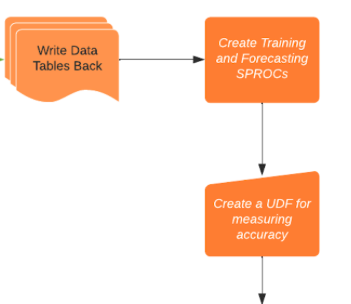

<h4>Table to call our UDF</h4>
As mentioned above we need a table to call our UDF on, so read our testing data to a table called 'test_spdf'
, <i>notice how fast the table reads,</i> that's one of the advantages of the Snowpark DataFrames. Also notice one of the biggest downsides of Snowpark DataFrames though, <i>they format horribly.</i> 

In [ ]:
%time
test_spdf = session.table("demo_testing_data")

test_spdf.show()

<h4>Now let's call our UDF</h4>
We are going to save the output of our UDF as a new table called 'out'. Then we want to select a bunch of input rows and use <code>call_udf()</code> to call our UDF and then pass it our columns in list format. Finally, we <i>save this as a new column called 'measured_accuracy'.</i>

In [ ]:
%%time

out = test_spdf.select('"total_sales"','"previous_days_units_sold"', '"avg_prev_week_units_sold"', '"day_of_week"',
                 '"total_units_sold_28_days"','"total_units_sold_30_prd_mv_avg"','"unit_price"','"holiday"',
                 '"lateinmonth"','"target"', call_udf("measure_accuracy", 
                 array_construct(
                     col('"total_sales"'), col('"previous_days_units_sold"'), col('"avg_prev_week_units_sold"'), 
                     col('"day_of_week"'), col('"total_units_sold_28_days"'), col('"total_units_sold_30_prd_mv_avg"'), 
                     col('"unit_price"'), col('"holiday"'), col('"lateinmonth"'), col('"target"'))).as_("MEASURED_ACCURACY"))

<h4>Let's take a look at our measured accuracy</h4>
To do this make a pandas DataFrame, use <code>describe()</code> to see how many corrects we got, and then express that as a percentage.

In [ ]:
table = out.to_pandas()

In [ ]:
table["MEASURED_ACCURACY"].describe()

In [ ]:
print("our measured accuracy is " + str(((4489 / 5000) * 100)) + " percent")

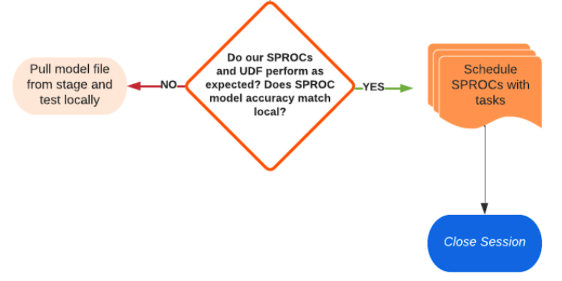

<h4>Visual Exploration</h4>
Now take advantage of this newly generated table to <font style = "text-decoration: underline">see where our model is incorrect</font>. If we take a look at the first graph here we can see that <code>avg_prev_week_units_sold</code> and <code>total_units_sold_28_day_max</code> do not seem to have any corelation relating to accuracy of our model. However, if we take a look at our second graph, we can see that <code>unit_price</code> outliers, where the indiviual unit is particularly high, the model consistently gets correct. This makes sense, as the more expensive an item is, the less likely it is to deviate from the average by a significant amount. 

In [ ]:
import seaborn as sns

sns.scatterplot(
    data=table,
    x="avg_prev_week_units_sold",
    y="total_units_sold_28_days",
    hue="MEASURED_ACCURACY",
)

In [ ]:
sns.scatterplot(
    data=table, x="unit_price", y="previous_days_units_sold", hue="MEASURED_ACCURACY"
)

### Task Creation
Without creating a task, the Stored Procedure we just created is essentially just another UDF that has to be manually called. In order to show off how we can <font style = "text-decoration: underline">schedule the Binary Classifier and Forecasting Stored Procedures</font> we will:  
<ol><li> Create tasks</li>
    <li> Start the tasks </li>
    <li> See all tasks </li>
    <li> Pause the tasks </li>
    <li> Delete the tasks </li></ol>
    
<font color = "#cc0000"><h3>DISCLAIMER:</h3> <p>Due to Snowpark's <b>lack of support for external network access</b>, we will not be able to update the data we are training on without rewriting a new table each time we run one of these Stored Procedures. This is obviously not ideal for binary_classifier -- a process that runs once a month -- but it is not horrible if the dataset is small. However for forecasts that we run once a day, this is completely unfeasible.</p></font>

<font color = "#cc0000"><b>Snowflake has said that this feature will come out soon</b>, so for the sake of the demo we will act as if we are not rewriting every time.</font>

In [ ]:
#Ensure you have the appropriate permissions (Execute Task)
privileges = session.sql('SHOW GRANTS to ROLE AI_LINK').collect()
task_priv = 'EXECUTE TASK' in str(privileges)
print(permissions["snowflake_role"],"has task privilege:", task_priv)

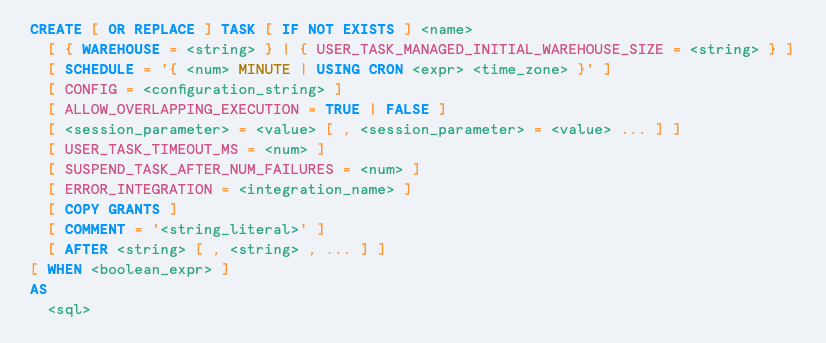
<p style = "text-align: center">This is the <b>full formula</b> for how to create a task</p>

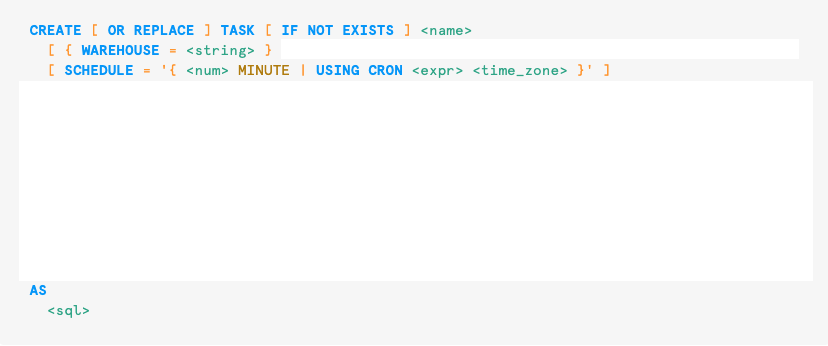<p style = "text-align: center">But this is the <b>minimum requirement formula</b>, and what we will be using today</p>

<p style = "text-align: center"><font style = "font-size: 16px" color = "#004AB8">Upon creation, each task is marked as <i>'Suspended,'</i> so we must <b>use the </b><code>ALTER</code><b> command to activate</b> tasks after</font></p>

In [ ]:
# Create binary classification task
session.sql(
    "CREATE OR REPLACE TASK binary_classifier WAREHOUSE = 'AI_LINK_XSMALL' SCHEDULE = 'USING CRON 0 15 10 * * UTC' AS CALL bi_class_demo('demo_training_demo', ['total_sales', 'previous_days_units_sold', 'avg_prev_week_units_sold', 'day_of_week', 'total_units_sold_28_day_max','total_units_sold_30_prd_mv_avg','unit_price', 'holiday', 'lateinmonth'], 'target');"
).show()

# Unsuspend
session.sql("ALTER TASK BINARY_CLASSIFIER RESUME;").show()

In [ ]:
# Create forecast task
session.sql(
    "CREATE OR REPLACE TASK forecast_avg WAREHOUSE = 'AI_LINK_XSMALL' SCHEDULE = 'USING CRON 0 6 * * * UTC' AS CALL forecast('DEMO_FORECAST_DATA');"
).show()

# Unsuspend
session.sql("ALTER TASK forecast_avg RESUME;").show()

In [ ]:
# See all Tasks
session.sql("SHOW TASKS").select(
    col('"name"'), col('"state"'), col('"created_on"'), col('"schedule"')
).to_pandas()

In [ ]:
# Suspend both Tasks
session.sql("ALTER TASK IF EXISTS binary_classifier SUSPEND;").show()
session.sql("ALTER TASK IF EXISTS forecast_avg SUSPEND;").show()

In [ ]:
# Delete both Tasks
session.sql("DROP TASK IF EXISTS BINARY_CLASSIFIER").show()
session.sql("DROP TASK IF EXISTS FORECAST_AVG").show()

<p><i>*Tip: the effects of the session.sql() statements seem to only work if you attach a .show() to the end of them.
</i>

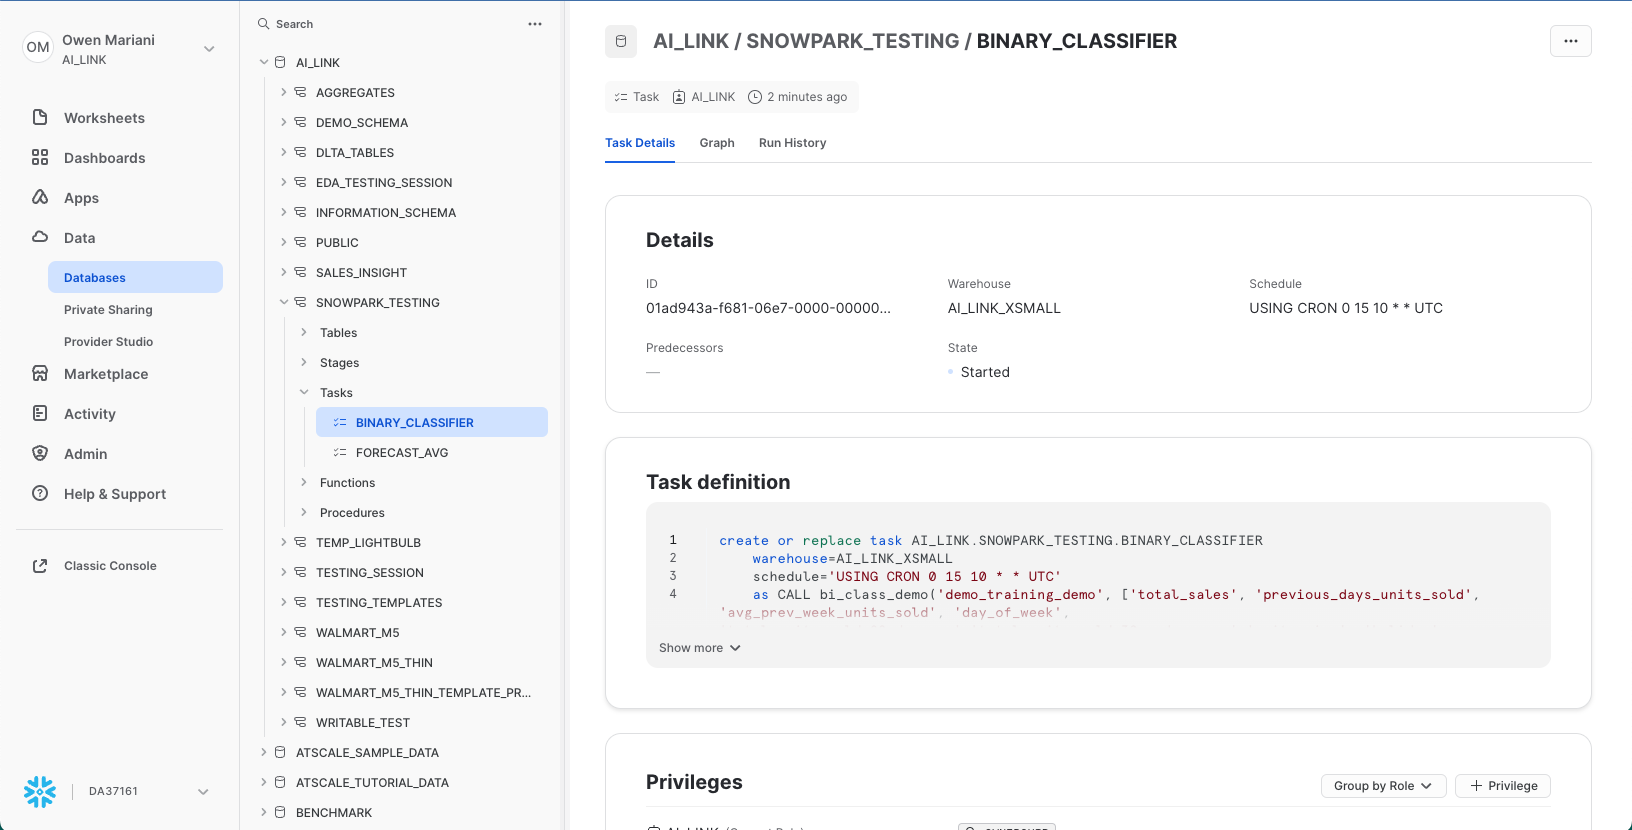
<p style = "text-align: center">You can also view your tasks in your databases in the <b>Data</b> tab</p>

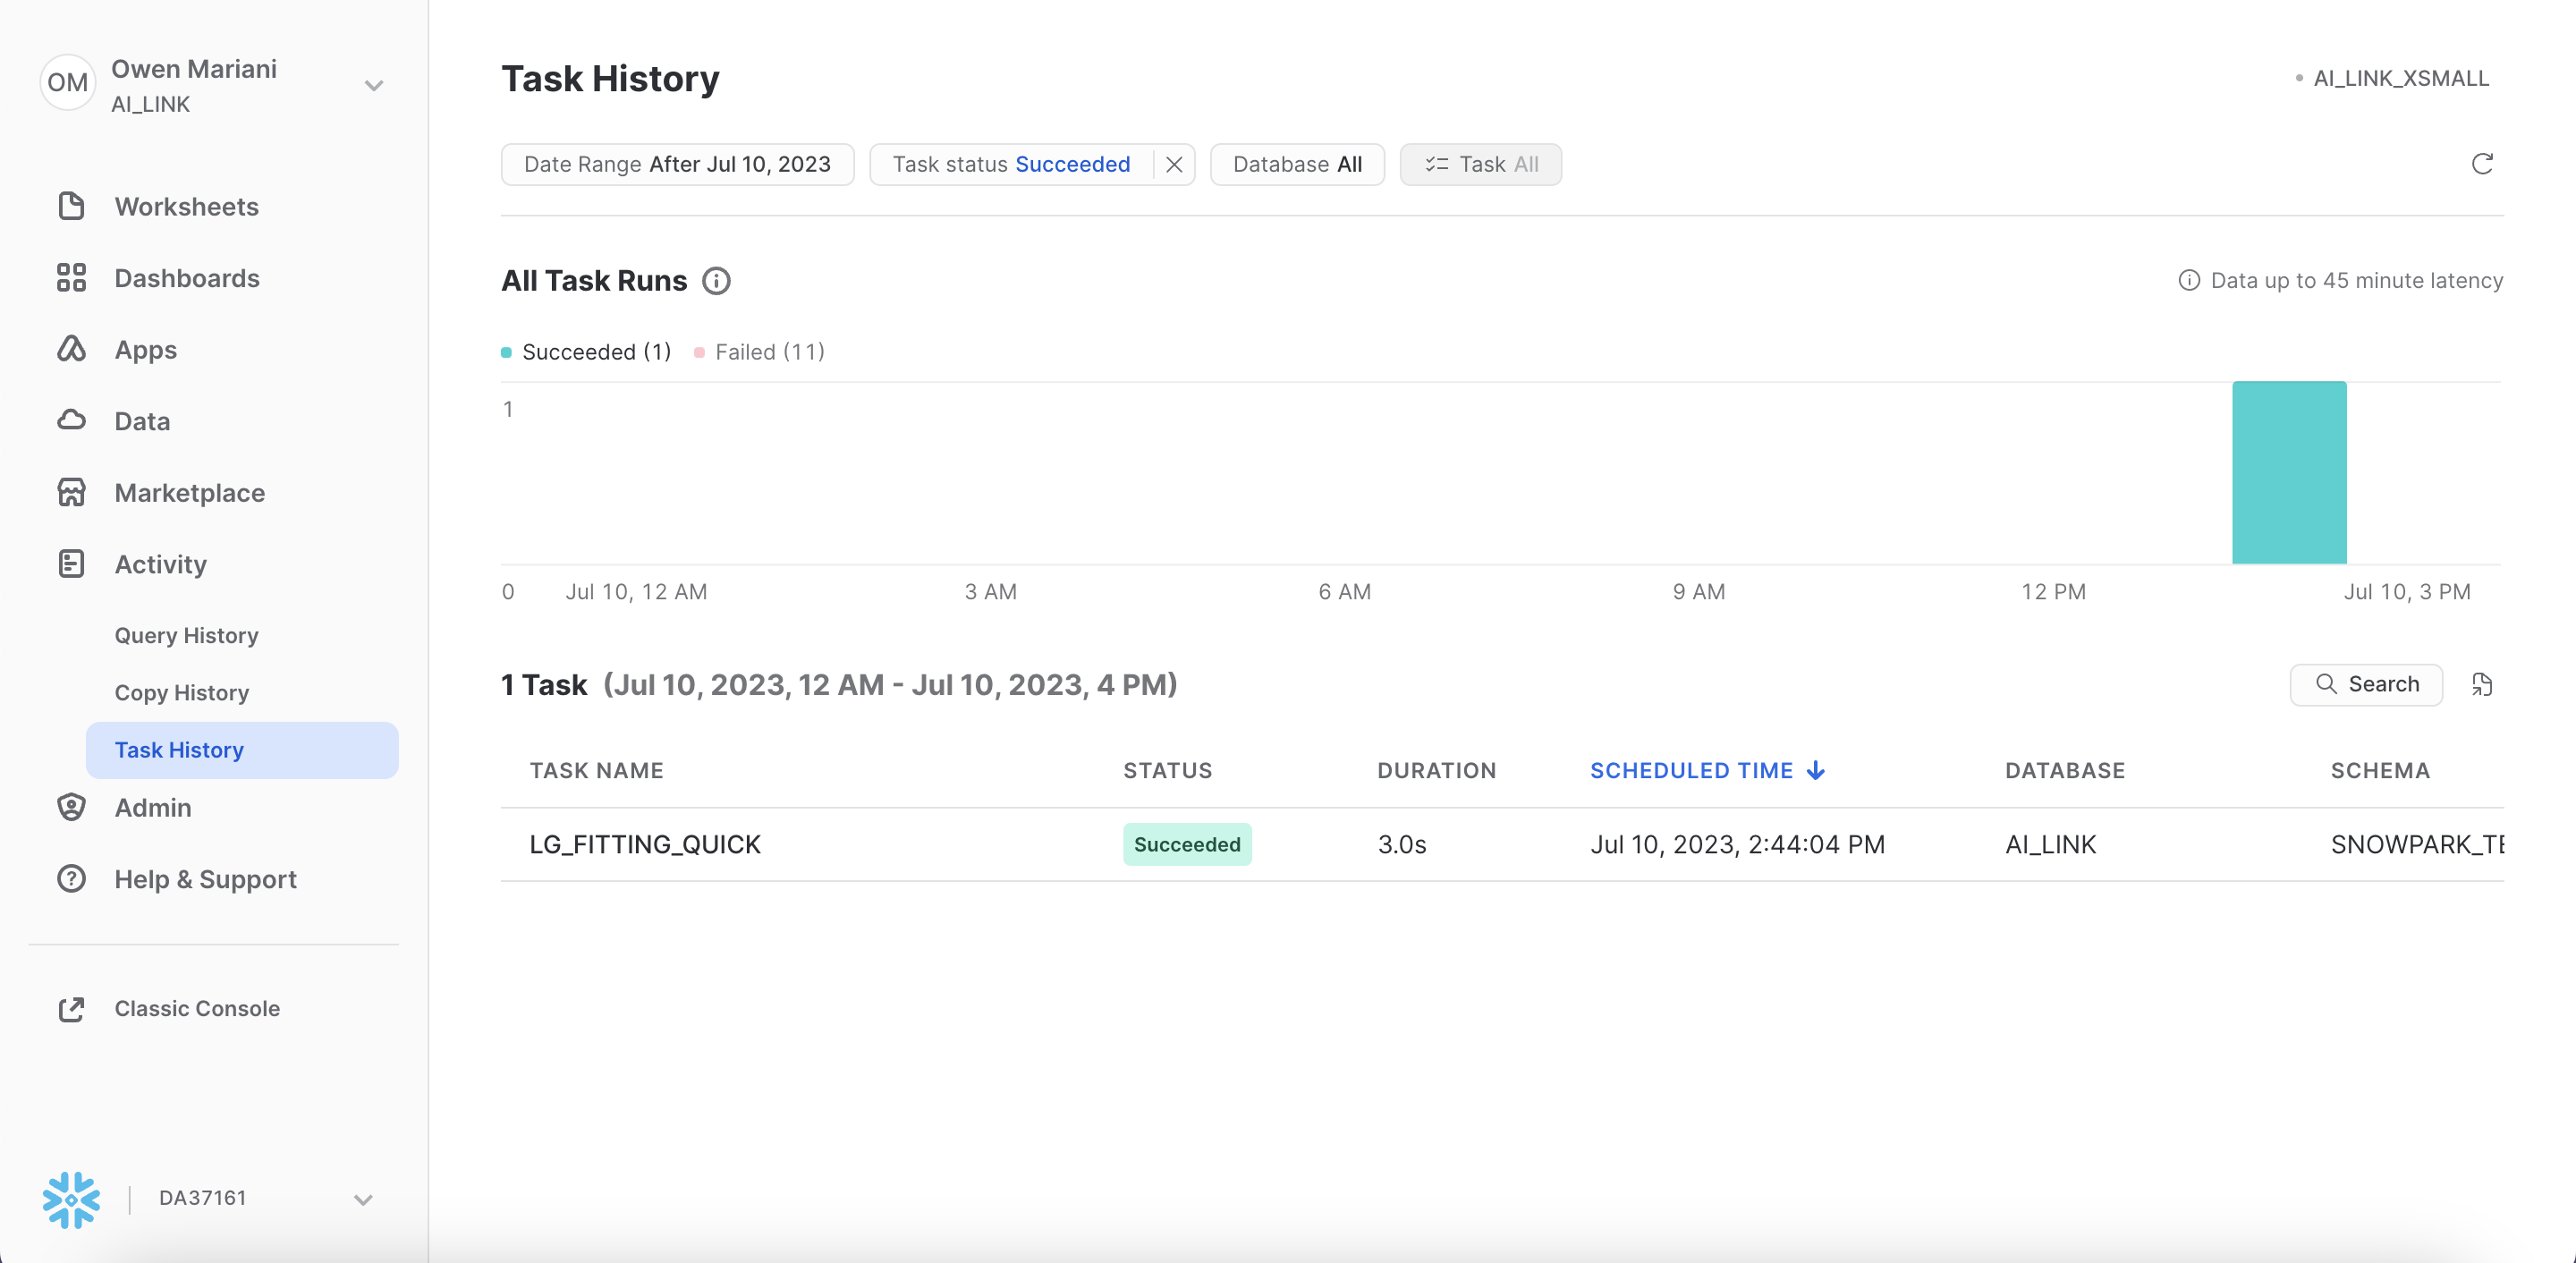
<p style = "text-align: center">In the <b>Activity</b> tab, you can check the progress of tasks</p>

In [ ]:
session.close()

### Summary

Using Snowpark and AI-Link we were able cover 3 main topics
<ol><li> Bringing our code to our data</li>
    <li> Automating training and forecasting </li>
    <li> Offering insights to our users </li></ol>
 

<div>
    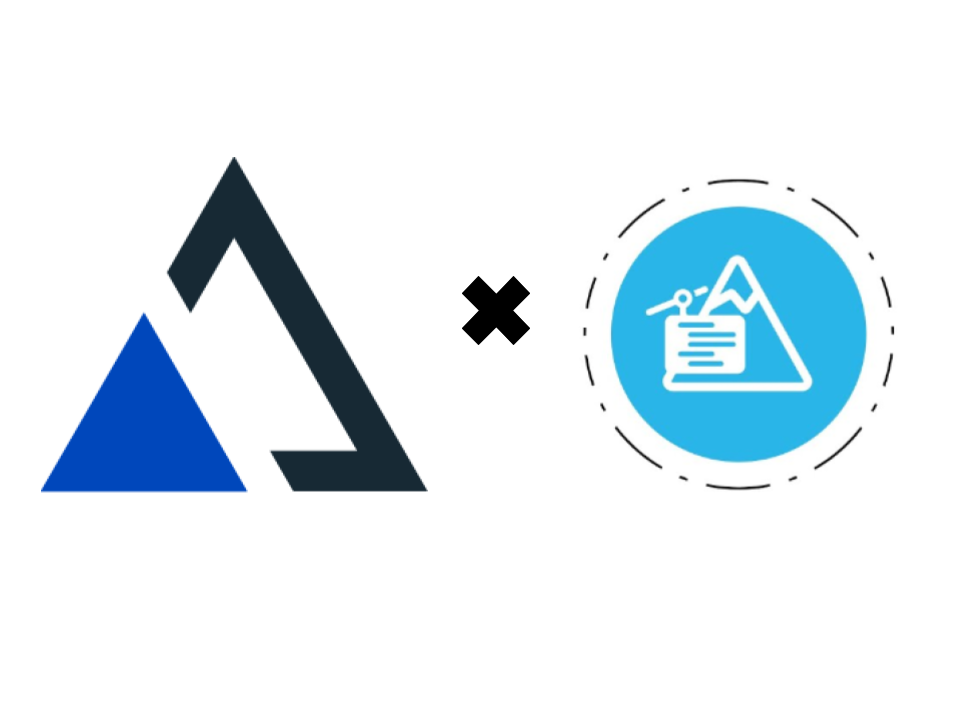
</div>